# Spectral Centroiding and Calibration

If we take a look at a typical a neon emission spectrum, (or any gas for that matter) we would see sharp emission peaks at very distinct wavelengths. This occurs because when atoms are energized (in the case of a neon lamp, by an electric current) they release photons, but they can only do so at several quantized energies (wavelengths). Think of the Bohr model of the atom. An energized electron can drop from the 4th to the 2nd energy level, or the 3rd to 2nd, or the 2nd to 1st, etc. Because those energy levels are quantized, the energies of the photons emitted when an electron falls n levels is also quantized. Every atom has a specific arrangement of electron orbitals that makes it such that the combination of wavelengths it can output due to electron cascading is unique (so a trained spectroscopist can look at almost any emission spectrum and recognize the element!). 

However, when we view spectra like the one we will plot below, we notice that the sharp peaks do in fact have a certain width, despite the description above indicating they should be perfect vertical lines at some defined wavelengths. There are numerous reasons for the widening: spectrometers introduce some widening (instrumental effects), fast moving gas has doppler shifts associated with some photons, and, at a theoretical level, we know from quantum physics that there is always imprecision in either the electron's position or momentum (though this would be a tiny effect in this situation). 

In any case, if we are to perform any sort of scientific analysis on a spectrum, we need to know for each of those peaks what our best guess for the single "right" wavelength for that line should be. One typical method of determining this is centroiding.

**What we will learn** In addition to the basics of actually centroiding a spectrum, this tutorial is meant as an introduction to loops and conditionals, the building blocks of most python code. 


## Quick Background

Centroiding amounts to finding the "center of mass" of a given peak. The formula for determining the centroid of a range of values (such as intensity/signal) is
\begin{equation}
x_{cm} = \frac{\sum x_iI_i}{\sum I_i}.
\end{equation}
where $x_i$ will end up being our wavelength (or pixel number) array, and "I" represents intensity (or Brightness, or # of photons/unit time) at each pixel value. It basically represents a "weighted average" of the peak. Note: we can't simply choose the x value where the peak hits its maximum because the limitations of the spectrometer result in the true "peak value" not lining up with the real wavelength we are looking for. This weighted average of the whole peak provides a better guess. Think about it, just because one extra photon happens to pile into pixel x, doesn't mean pixel x is representitive of that spectral line.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)
#Load up neon spectrum 
pixels = np.loadtxt('neon.txt',usecols=(0,), dtype=int) #take zeroth column
signal = np.loadtxt('neon.txt',usecols=(1,)) #take first column

So now we have a pixel and signal array. Our goal is to find the centroid of all the peaks in the plot. Speaking of, let's plot pixels vs signal just to get an idea of what were are looking at:

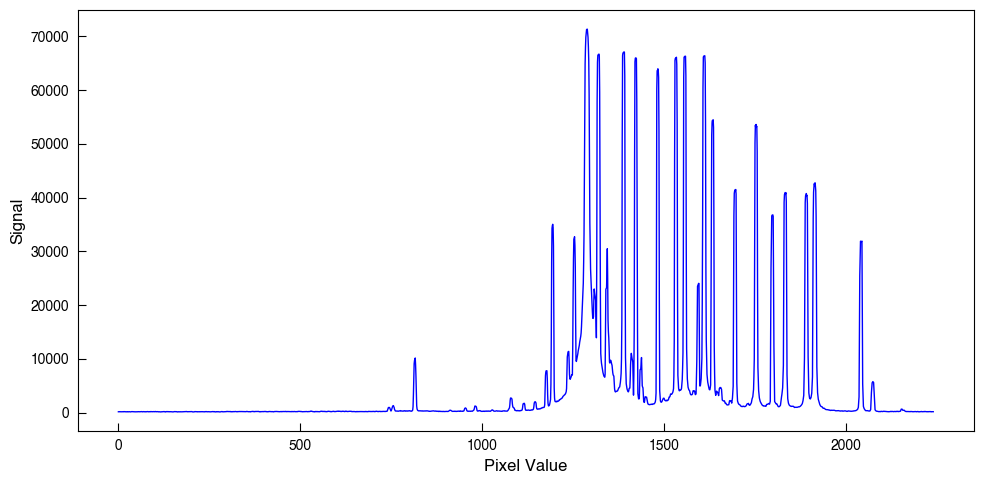

In [3]:
plt.plot(pixels,signal,'b') #fill in what to plot, then run this cell again to see if it matches
plt.xlabel('Pixel Value')
plt.ylabel('Signal')
plt.show()

Notice there are quite a few jitters there. We are only interested in the major features, so when we are performing the following analysis, it would probably be smart to implement some sort of threshold (say, 20,000?) to catch only the major peaks. 

In order to find the centroid of each peak, we need to first determine the peaks in the first place. Let's go ahead and write a peak-finding algorithm. There are many ways to do this, so feel free to try your own. My suggestion is as follows (try it in the space below): 

1. Iterate over a range that's the length of the pixel array (or signal, they're the same length by construction) checking whether each value of signal is higher or lower than the value of signal one to the left and one to the right.
2. If you want to be extra robust, check whether it is in fact higher than its two left and right neighbors. 
3. If it is, call it a peak and append that index where the peak occurs out into a separate array.

I've started the loop for you:

In [8]:
#Find the peaks 

threshhold =  30000 #You can just pick slightly lower than the lowest peak you want to centroid
peaks = []    #x positions of the peaks, or rather, their index
for i in range(len(signal)-1): #len(signal)-1 because you will be checking the value after than your last i 
    if (signal[i] > threshhold) and (signal[i] > signal[i-1]) and (signal[i] > signal[i+1]):  #three conditions to be a peak
        if (signal[i] > signal[i-2]) and (signal[i] > signal[i+2]):
            peaks.append(i)
print(len(peaks))

22


We should now have the positions (in pixel space) where the peaks occur. We now want to calculate the centroid in a region around each peak. This raises a bit of an issue- how wide do we make that region? Too narrow and we don't include the whole peak, too wide and we are biased or influenced by things not actually a part of the peak. 

Turns out, most astronomers' solution to this issue is to use a standardized region known as the Full Width (at) Half Maximum (or FWHM). What this means is we want to use a region that is as wide as where the peak has dropped to half its maximum value. This works well, because the width will automatically be adjusted to handle larger and smaller peaks, and the same "amount" of each peak is being used in our calculation. 


In the space below, iterate over the peaks we just found, and determine the FWHM (in this case it will be very narrow because our spectrometer did not have very high resolution). I suggest defining an xmin and xmax, and using the "np.where" function to search out where the signal array drops below the half max value (easily calculated by taking signal indexed at "i" and dividing by 2). Using that FWHM, caculate the center of mass of each peak, and append the final pixel positions of the centers of mass to a new array/list. Remember that you can sum arrays (and arrays times arrays) without iterating!

In [9]:
centroids = [] #Values for all the centroids
for i in peaks:
    #Calculate how far backward and forward to go:
    half_max = signal[i]/2
    xmin =  np.where(signal[i::-1] < half_max)[0] #Recall the syntax for indexing in reverse from a given element              
    xmax =  np.where(signal[i:] < half_max)[0]    #remember when using np.where to index [0], and at that point you still have an array- but you are likely interested in the first value of it
    x_range = pixels[i-xmin[0]:i+xmax[0]]
    I_range = signal[x_range]
    x_range = np.array(x_range)
    I_range = np.array(I_range)
    xcm = np.sum(x_range*I_range) / np.sum(I_range)
    centroids.append(xcm)

Awesome! Now we have our centroids. Lets go ahead and plot the centroids as vertical, dashed lines over our data. As this is a somewhat trivial syntax lookup, I've just gone ahead and included it here: 

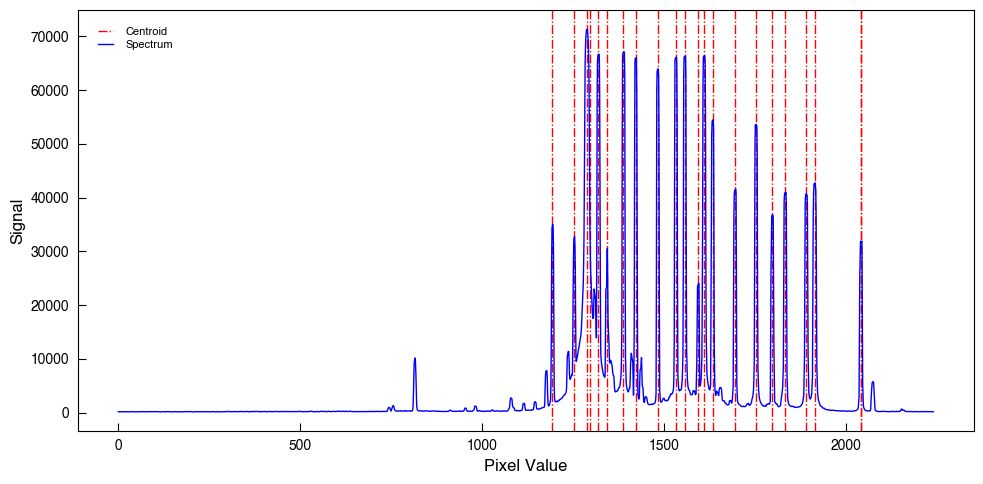

In [10]:

def plot_vert(x): 
    '''
    Just plots vertical lines, in red dashes
    '''
    plt.axvline(x, color='red', ls='-.')
    
for i in centroids[1:]: #Call my plotting function on every centroid except the first
    plot_vert(i)
    
plt.axvline(centroids[0],color='red',ls='-.',label='Centroid') #Reserve the first so I don't have a million "centroid" labels
plt.plot(pixels, signal, 'b', label='Spectrum') #Plot the actual spectrum
plt.xlabel('Pixel Value')
plt.ylabel('Signal')
plt.legend(loc=2)
plt.show() #Show it
#Re-run yourself to replace with your graph and see if it matches

Looks like we've done this correctly; the vertical lines line up with the peaks of the spectrum, roughly (they shouldn't be at the exact peak, if we calculated our centers of mass correctly. In fact, let's plot this just to show ourselves that we did in fact get something different. We still have our "peaks" array, which contains the pixel positions of the peak values. Let's plot a "residual" (not exactly a residual in a scientific context, but close enough)- plot the difference between the peaks array and the centroids array against a new x-array that is just a range the length of the peaks/centroids array, to get a feel for whether the centroids were actually any different than the peaks:

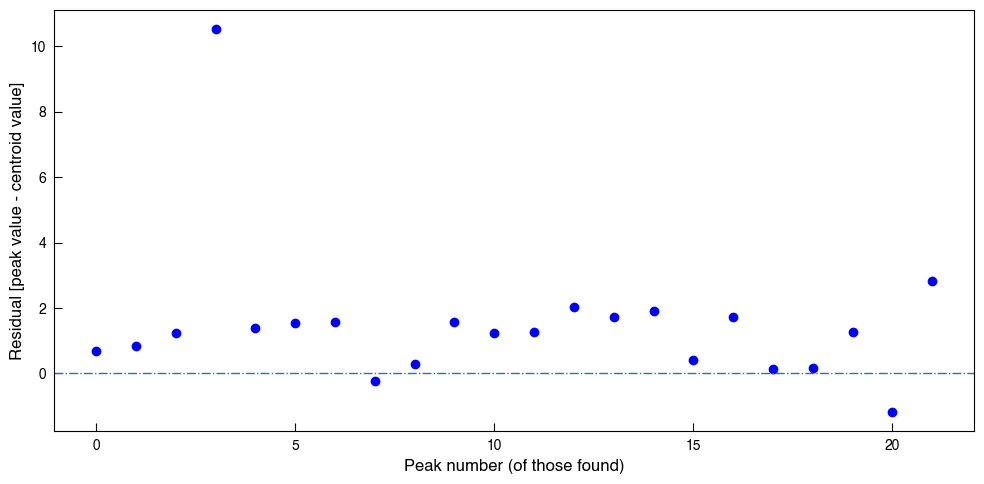

In [11]:
residual = np.array(peaks) - np.array(centroids)
plt.plot(np.arange(len(residual)),residual,'bo')
plt.xlabel('Peak number (of those found)')
plt.ylabel('Residual [peak value - centroid value]')
plt.axhline(0,ls='-.')
plt.show()

We can see in the plot above several things, the first being that there is definitely a difference between the peak value and the centroid value, sometimes by as much as 3 pixels (this is of course specific to this spectrum taken with this spectrometer- values will differ). Secondly, we ca see that they seem to be randomly distributed, but perhaps slightly weighted to being above zero rather than below. Assuming no systematics (of which there are likely several here), we would expect roughly half the points to be negative (roughly have the centroids be to the left of the peak and half to the right). 

We would want to, as scientists, explore further why this bias might exist. Is there bias in how we are calculating our FWHM (perhaps accidentally weighting to the right? Perhaps the spectrograph itself has a slight systematic bias towards shuffling incoming photons into slightly higher wavelength bins than they should be? Perhaps, in some inherent sense, the shape of neon spectral peaks is not symmetric but is in fact slightly asymmetric? 

Good questions to ask and interrogate, and which will be left as an exercise to the reader (I've always wanted to say that!)

A final note: you might be asking "What do I do now, with the centroids?" Often, your next step would be calibrating your spectrometer. Notice our x-axis units have been pixels- that is, there is a CCD (charge coupled device) in the spectrometer, and a diffraction grating (acting the way a prism does) to deflect light of different wavelengths/energies onto different pixels in the CCD. We would of course rather like to know what wavelengths these emission lines correspond to. Thus, we need to know the pixel to wavelength ratio of our spectrometer. By recognizing certain lines (a skill invaluable to spectroscopists and that often involves squinting at other spectra looking for similarities), we can map our 20 calculated centroids to 20 known wavelengths for those lines, and through a fitting proccess determine the formula to then turn any pixel in our ccd into a wavelength. 


As always, I hope you enjoyed the tutorial, practiced some python, and learned a little astro along the way! Feel free to raise an issue on the github if there's a problem with this tutorial, you have questions, or you want to give any other sort of feedback!